# Let us Start by Importing Libraries required

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longit # Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print("done")

done


### Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.


In [2]:
def geo_location(address):
   # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer") 
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'MZ2QVF3VPSM5WLV1GOB44VQPSQDZVUQ4BRBITS02NT2W0Z0W' # your Foursquare ID
    CLIENT_SECRET ='USP4F2JXEXB2LMU1MMGGXUIJOYJTVM3QL30YVYXJPK5ATAD1' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data= results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
CLIENT_IDI = 'Z4A4QJX4ILQY5K0PCCEBGQSC2K4LZJGFH3N24WFTZ4V5GMFR' # your Foursquare ID
CLIENT_SECRETI ='E5XKEDSOCMSRFLDTWDSHRRXIFIKC3WETYCLFKBT0GFBUYGGV'# your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [5]:

def get_venue_details(venue_id):
        
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_IDI, 
            CLIENT_SECRETI, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
# get new york data
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

In [10]:
#So there are total of 306 different Neighborhoods Venues in New York and 5 Boroughs 

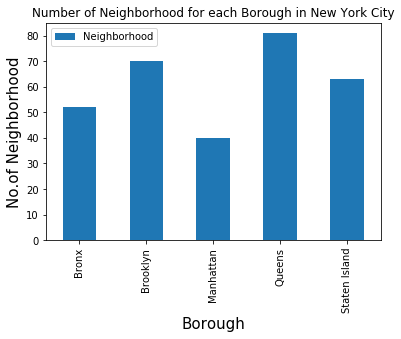

In [12]:
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Now we will collect Mexican resturants for each Neighborhood

In [13]:
# prepare neighborhood list that contains mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
max_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    max_resturants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(new_york_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(max_resturants)))
    for resturant_detail in max_resturants.values.tolist():
        id, name , category=resturant_detail
        max_rest_ny = max_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:2
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:2
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:2
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:6
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:3
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:3
( 10 / 306 ) Mexican Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Mexican Resturants in Baychester, Bronx:2
( 12 / 306 ) Mexican Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Mexican Resturants in City Island, Bronx:0
( 14 / 306 ) Mexican Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Mexican Resturants in University Heights, Bronx:0
( 16 / 306 ) Mexican Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Mexican Resturants in Fordham, Bronx:1
( 18 / 306 ) Mexican Resturants in East Tremont, Bronx:

In [21]:
max_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar
4,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente


In [18]:
max_rest_ny.shape

(326, 4)

### We have here total 326 Mexican Restaurants 

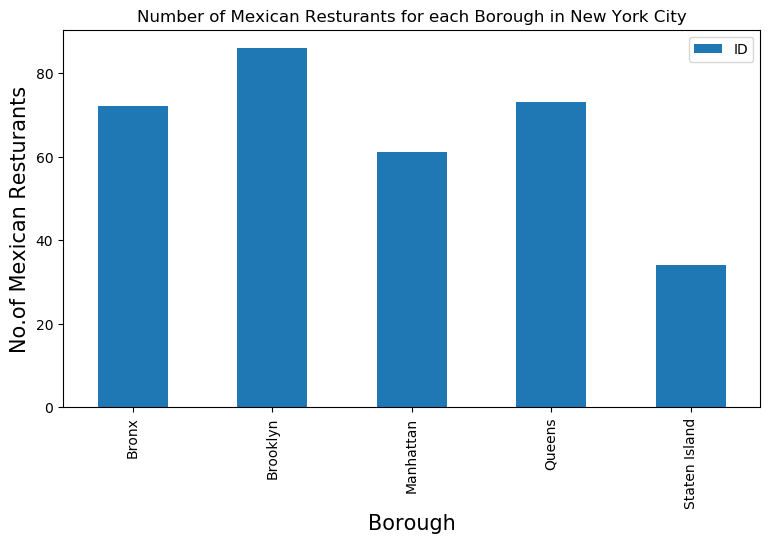

In [22]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
max_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Brooklyn has largest number of restaurants 

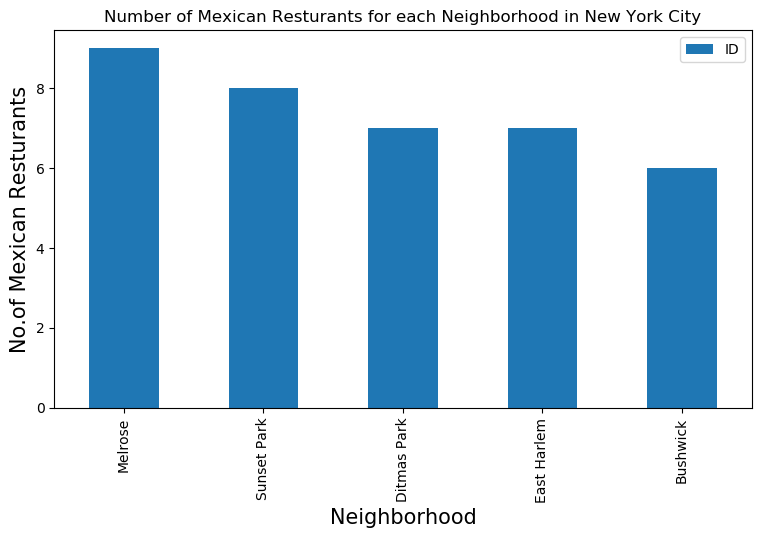

In [23]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
max_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [25]:
max_rest_ny[max_rest_ny['Neighborhood']=='Melrose']

,Borough,Neighborhood,ID,Name
25,Bronx,Melrose,4b46a46ef964a5201d2626e3,Xochimilco Family Restaurant
26,Bronx,Melrose,4bf1b1ef3fa220a150991820,Mexicocina
27,Bronx,Melrose,54bc5fe2498e8ddf27d64304,Mexicozina Taqueria
28,Bronx,Melrose,50746051f13668d669c6b9ed,Mexicocina
29,Bronx,Melrose,5591837d498ee4167d48bb73,Cinco de Mayo
30,Bronx,Melrose,4e1796f0aeb7eb0120c2f796,Taco Mx
31,Bronx,Melrose,563ba7d9cd109b358ed35cd5,Lupita's Restaurant
32,Bronx,Melrose,4e760eb418506506ccae1213,El Atoradera
33,Bronx,Melrose,4bd89d7af645c9b6e87aa8e0,Nuevo Delicioso


In [26]:
# prepare neighborhood list that contains Mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
max_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in max_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(max_rest_ny),')','processed')
    max_rest_stats_ny = max_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
  

                         ID                    Name  Likes  Rating  Tips
0  5c47a4b21953f3002c558218  Chipotle Mexican Grill      0     7.5     0
( 1 / 326 ) processed
                         ID                   Name  Likes  Rating  Tips
0  58582b156431e554e165d909  Moe's Southwest Grill      1     6.5     0
( 2 / 326 ) processed
                         ID          Name  Likes  Rating  Tips
0  523f6e14498ef6fdefc0d690  Burrito Shop     10     6.9     4
( 3 / 326 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4b78ba71f964a5209fdf2ee3  Santa Fe Grill & Bar     11     6.3    17
( 4 / 326 ) processed
                         ID           Name  Likes  Rating  Tips
0  590e5d2ce96d0c61de2dcf1d  Cocina Chente     13     8.8     5
( 5 / 326 ) processed
                         ID    Name  Likes  Rating  Tips
0  4db45c96fa8c350240e35919  Metate     19     6.4    10
( 6 / 326 ) processed
                         ID                  Name  Likes  Rating  Ti

In [27]:

max_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.5,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,6.9,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.3,17
4,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente,13,8.8,5


In [28]:

max_rest_stats_ny.shape

(326, 7)

In [29]:

max_rest_ny.shape

(326, 4)

##### So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [30]:
max_rest_stats_ny.to_csv('mexican_rest_stats_ny.csv', index=False)

In [31]:
mexican_rest_stats_ny_csv=pd.read_csv('mexican_rest_stats_ny.csv')

In [32]:
mexican_rest_stats_ny_csv.shape

(326, 7)

In [33]:
mexican_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.5,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,6.9,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.3,17
4,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente,13,8.8,5


In [34]:
mexican_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 7 columns):
Borough         326 non-null object
Neighborhood    326 non-null object
ID              326 non-null object
Name            326 non-null object
Likes           326 non-null int64
Rating          326 non-null float64
Tips            326 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 18.0+ KB


In [35]:
max_rest_stats_ny['Likes']=max_rest_stats_ny['Likes'].astype('float64')


In [36]:
max_rest_stats_ny['Tips']=max_rest_stats_ny['Tips'].astype('float64')

In [37]:
max_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 7 columns):
Borough         326 non-null object
Neighborhood    326 non-null object
ID              326 non-null object
Name            326 non-null object
Likes           326 non-null float64
Rating          326 non-null float64
Tips            326 non-null float64
dtypes: float64(3), object(4)
memory usage: 18.0+ KB


In [38]:

# Resturant with maximum Likes
max_rest_stats_ny.iloc[max_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1977
Rating                                 9
Tips                                 720
Name: 172, dtype: object

In [39]:
# Resturant with maximum Rating
max_rest_stats_ny.iloc[max_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a38273a005ac129b7a93010
Name                        La Loncheria
Likes                                 51
Rating                               9.2
Tips                                  15
Name: 94, dtype: object

In [40]:
# Resturant with maximum Tips
max_rest_stats_ny.iloc[max_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1977
Rating                                 9
Tips                                 720
Name: 172, dtype: object

###### Now lets visualize neighborhood with maximum average rating of resturants

In [41]:
ny_neighborhood_stats=max_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [42]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
78,Little Italy,9.000000
98,Noho,9.000000
128,Soho,9.000000
39,East Village,9.000000
151,Windsor Terrace,8.900000
47,Flatiron,8.900000
150,Willowbrook,8.800000
57,Gramercy,8.766667
59,Greenpoint,8.750000
106,Park Slope,8.700000


#### Above are the top neighborhoods with top average rating of Mexican resturants

In [43]:
ny_borough_stats=max_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [44]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.181967
3,Queens,7.523288
1,Brooklyn,7.248837
0,Bronx,6.345833
4,Staten Island,6.073529


#### Similarly these are the average rating of Mexican Resturants for each Borough

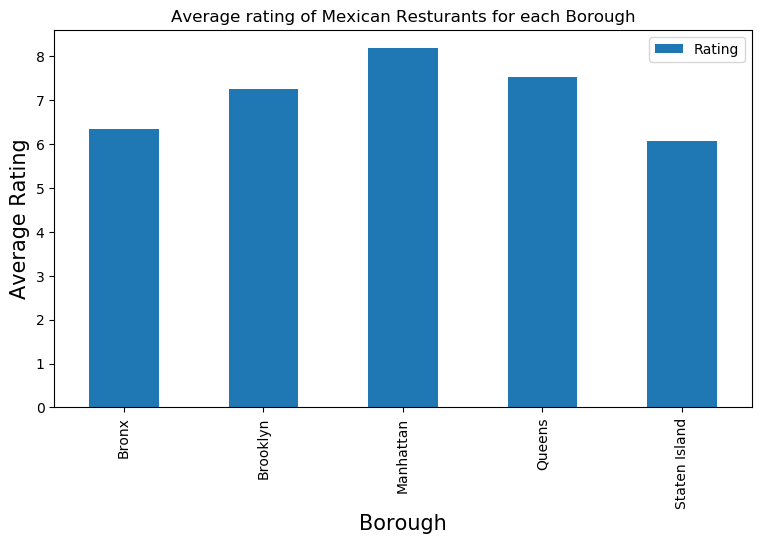

In [45]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Mexican Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
max_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [54]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]          

In [55]:
ny_neighborhood_stats

,Neighborhood,Average Rating
39,East Village,9.0
78,Little Italy,9.0
98,Noho,9.0
128,Soho,9.0


In [56]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [57]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [59]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,East Village,40.727847,-73.982226,9.0
1,Manhattan,Little Italy,40.719324,-73.997305,9.0
2,Manhattan,Noho,40.723259,-73.988434,9.0
3,Manhattan,Soho,40.722184,-74.000657,9.0


In [60]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [61]:

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [62]:
#let's add new field to dataframe for labelling 

In [63]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [64]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [65]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

json_url=r'USA New York City neighborhood 20190128.geojson'
ny_map.choropleth(
    geo_data=json_url,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
ny_map




# Conclusion 
#### We can conclude that Manhattan have the potential market for Mexican restaurants
#### Astoria(Queens), Blissville(Queens) and Civic Center(Manhattan) have some of the major Mexican Restaurants  


# Limitations
#### Based on Foursquare limited Data
#### Based purely on ratings